<a href="https://colab.research.google.com/github/himsgpt/GenAI_agents/blob/main/Agent_memory_redis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# !pip install redis
# !pip install langchain-openai langgraph-checkpoint langgraph langgraph-checkpoint-redis langchain-redis
# !pip install sentence-transformers


Short term memory: The agent tracks chat history using Redis through LangGraph's checkpointer. Each node in the graph (Retrieve Memories, Respond, Summarize) saves its state to Redis, including conversation history and thread metadata

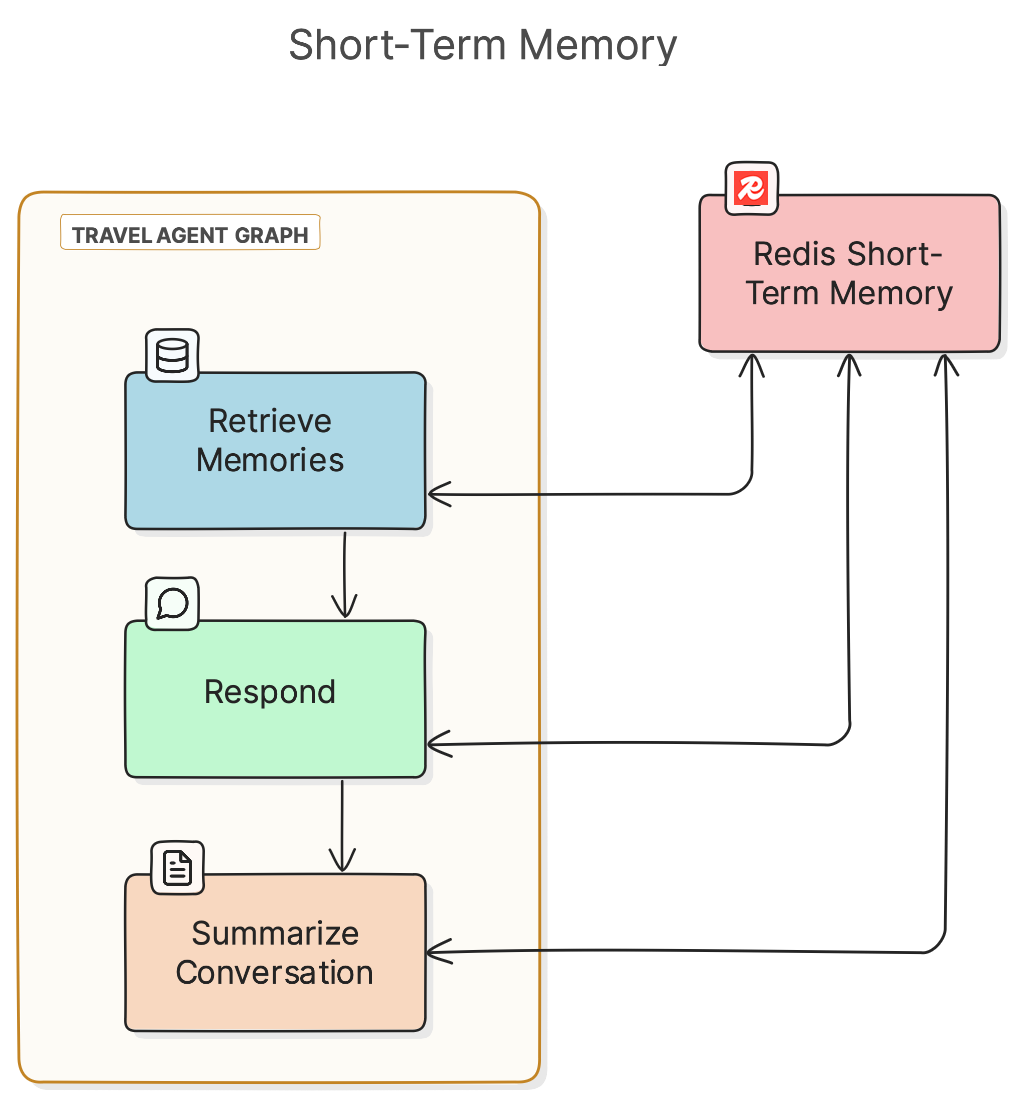

Long term memory: Long-term memories are stored & indexed in Redis using the RedisVL client, with two types:

Episodic: User preferences and experiences \n

Semantic: General travel knowledge
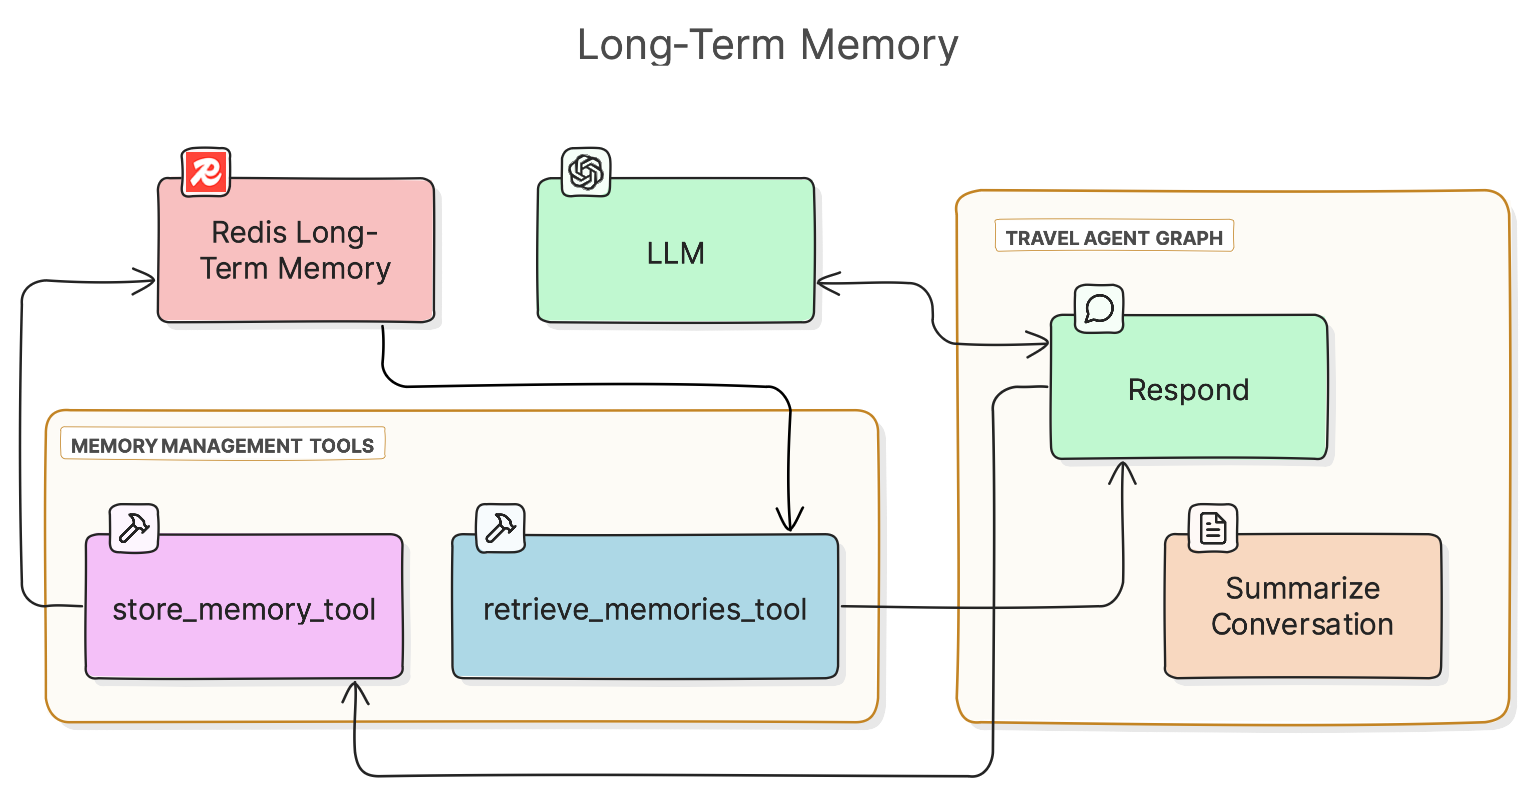

Setup Redis
You have two options for running Redis:

Redis Cloud: For a fully-managed, seamless experience, use a free instance of Redis Cloud.

Local Redis: For a simple, local (non-persistent) Redis instance, run the cell below.

In [4]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


In [5]:
import os
from redis import Redis
# Use the environment variable if set, otherwise default to localhost
REDIS_URL = os.getenv("REDIS_URL", "redis://localhost:6379")
redis_client = Redis.from_url(REDIS_URL)
redis_client.ping()

True

Prepare memory data models
In this section, we'll create a robust data modeling system for our agent's memory using Pydantic. These models will ensure type safety and provide clear data structures for storing and retrieving memories from Redis.

We'll implement four key components:
MemoryType - An enumeration that categorizes memories into two types:

**Episodic**: Personal experiences and user preferences

**Semantic**: General knowledge and domain facts

**Memory** - The core model representing a single memory entry with its content and metadata

**Memories** - A container model that holds collections of memory objects

**StoredMemory** - A specialized model for memories that have been persisted to Redis

Now we have type-safe data models that handle the complete memory lifecycle from LLM extraction to Redis storage, with proper metadata tracking for production use. Next, we'll set up the Redis infrastructure to store and search these memories using vector embeddings.

In [11]:
import ulid
from datetime import datetime
from enum import Enum
from typing import List, Optional
from pydantic import BaseModel, Field


class MemoryType(str, Enum):
    """
    Defines the type of long-term memory for categorization and retrieval.

    EPISODIC: Personal experiences and user-specific preferences
              (e.g., "User prefers Delta airlines", "User visited Paris last year")

    SEMANTIC: General domain knowledge and facts
              (e.g., "Singapore requires passport", "Tokyo has excellent public transit")

    The type of a long-term memory.

    EPISODIC: User specific experiences and preferences

    SEMANTIC: General knowledge on top of the user's preferences and LLM's
    training data.
    """

    EPISODIC = "episodic"
    SEMANTIC = "semantic"


class Memory(BaseModel):
    """Represents a single long-term memory."""

    content: str
    memory_type: MemoryType
    metadata: str


class Memories(BaseModel):
    """
    A list of memories extracted from a conversation by an LLM.

    NOTE: OpenAI's structured output requires us to wrap the list in an object.
    """

    memories: List[Memory]


class StoredMemory(Memory):
    """A stored long-term memory"""

    id: str  # The redis key
    memory_id: ulid.ULID = Field(default_factory=lambda: ulid.ULID())
    created_at: datetime = Field(default_factory=datetime.now)
    user_id: Optional[str] = None
    thread_id: Optional[str] = None
    memory_type: Optional[MemoryType] = None

**Schema Define**

Short-term memory is handled automatically by RedisSaver from langgraph-checkpoint-redis.

For long-term memory, we'll use RedisVL with vector embeddings to enable semantic search of past experiences and knowledge

In [12]:
from redisvl.index import SearchIndex
from redisvl.schema.schema import IndexSchema


# Define the schema for our vector search index
# This creates the structure for storing and querying memories
memory_schema = IndexSchema.from_dict({
        "index": {
            "name": "agent_memories",  # Index name for identification
            "prefix": "memory",       # Redis key prefix (memory:1, memory:2, etc.)
            "key_separator": ":",
            "storage_type": "json",
        },
        "fields": [
            {"name": "content", "type": "text"},
            {"name": "memory_type", "type": "tag"},
            {"name": "metadata", "type": "text"},
            {"name": "created_at", "type": "text"},
            {"name": "user_id", "type": "tag"},
            {"name": "memory_id", "type": "tag"},
            {
                "name": "embedding",
                "type": "vector",
                "attrs": {
                    "algorithm": "flat",
                    "dims": 1536,  # OpenAI embedding dimension
                    "distance_metric": "cosine",
                    "datatype": "float32",
                },
            },
        ],
    }
)

In [13]:
try:
    long_term_memory_index = SearchIndex(
        schema=memory_schema,
        redis_client=redis_client,
        validate_on_load=True
    )
    long_term_memory_index.create(overwrite=True)
    print("Long-term memory index ready")
except Exception as e:
    print(f"Error creating index: {e}")

Long-term memory index ready


In [14]:
!rvl index info -i agent_memories



Index Information:
╭────────────────┬────────────────┬────────────────┬────────────────┬────────────────┬╮
│ Index Name     │ Storage Type   │ Prefixes       │ Index Options  │ Indexing       │
├────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼┤
| agent_memories | JSON           | ['memory']     | []             | 0              |
╰────────────────┴────────────────┴────────────────┴────────────────┴────────────────┴╯
Index Fields:
╭─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬╮
│ Name            │ Attribute       │ Type            │ Field Option    │ Option Value    │ Field Option    │ Option Value    │ Field Option    │ Option Value    │ Field Option    │ Option Value    │
├─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────

# Functions to access memories:

we provide three core functions to access, store and retrieve memories

In [18]:
# from redisvl.utils.vectorize.text.openai import OpenAITextVectorizer

# openai_embed = OpenAITextVectorizer(model="text-embedding-ada-002")
from sentence_transformers import SentenceTransformer

class LocalTextVectorizer:
    """Wrapper to match the interface of OpenAITextVectorizer"""
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)

    def embed(self, texts):
        # If single string, wrap in list for batch processing
        if isinstance(texts, str):
            texts = [texts]
        embeddings = self.model.encode(texts, normalize_embeddings=True)
        return embeddings[0] if len(embeddings) == 1 else embeddings

# Instantiate
local_embed = LocalTextVectorizer()

import logging

# Set up a logger
logger = logging.getLogger(__name__)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

1. **Check for similar memories**
First, we'll write a utility function to check if a memory similar to a given memory already exists in the index.

This function checks for duplicate memories in Redis by:

a. Converting the input content into a vector embedding

b. Creating filters for user_id and memory_type

c. Using vector similarity search with a vector range query to find any existing + similar memories

d. Returning True if a similar memory exists, False otherwise

This helps prevent storing redundant information in the agent's memory.

In [19]:
from redisvl.query import VectorRangeQuery
from redisvl.query.filter import Tag


# If we have any memories that aren't associated with a user, we'll use this ID.
SYSTEM_USER_ID = "system"


def similar_memory_exists(
    content: str,
    memory_type: MemoryType,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    distance_threshold: float = 0.1,
) -> bool:
    """Check if a similar long-term memory already exists in Redis."""
    content_embedding = local_embed.embed(content)

    filters = (Tag("user_id") == user_id) & (Tag("memory_type") == memory_type)

    if thread_id:
        filters = filters & (Tag("thread_id") == thread_id)

    # Search for similar memories
    vector_query = VectorRangeQuery(
        vector=content_embedding,
        num_results=1,
        vector_field_name="embedding",
        filter_expression=filters,
        distance_threshold=distance_threshold,
        return_fields=["id"],
    )
    results = long_term_memory_index.query(vector_query)
    logger.debug(f"Similar memory search results: {results}")

    if results:
        logger.debug(
            f"{len(results)} similar {'memory' if results.count == 1 else 'memories'} found. First: "
            f"{results[0]['id']}. Skipping storage."
        )
        return True

    return False

2. **Store long-term memories**
Below is a function that handles storing long-term memories in Redis with built-in deduplication.

It's a key part of our memory system that:

Prevents duplicate memories by checking for similar content
Creates vector embeddings for semantic search capabilities
Stores the memory with relevant metadata for future retrieval

In [20]:
from datetime import datetime
from typing import List, Optional, Union

import ulid
def store_memory(
    content: str,
    memory_type: MemoryType,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    metadata: Optional[str] = None,
):
    """Store a long-term memory in Redis with deduplication.

        This function:
        1. Checks for similar existing memories to avoid duplicates
        2. Generates vector embeddings for semantic search
        3. Stores the memory with metadata for retrieval
        """
    if metadata is None:
        metadata = "{}"

    logger.info(f"Preparing to store memory: {content}")

    if similar_memory_exists(content, memory_type, user_id, thread_id):
        logger.info("Similar memory found, skipping storage")
        return

    embedding = local_embed.embed(content)

    memory_data = {
        "user_id": user_id or SYSTEM_USER_ID,
        "content": content,
        "memory_type": memory_type.value,
        "metadata": metadata,
        "created_at": datetime.now().isoformat(),
        "embedding": embedding,
        "memory_id": str(ulid.ULID()),
        "thread_id": thread_id,
    }

    try:
        long_term_memory_index.load([memory_data])
    except Exception as e:
        logger.error(f"Error storing memory: {e}")
        return

    logger.info(f"Stored {memory_type} memory: {content}")

3. Retrieve relevant long-term memories
And now that we're storing memories, we can retrieve them using vector similarity search with metadata filters using RedisVL.

This function:

Takes a query string, optional filters (memory type, user ID, thread ID), and a distance threshold (semantic)
Creates a vector range query using the query's embedding
Builds a filter object based on passed options
Filters to narrow down the search results
Executes the search and returns parsed memory objects

In [21]:
def retrieve_memories(
    query: str,
    memory_type: Union[Optional[MemoryType], List[MemoryType]] = None,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    distance_threshold: float = 0.1,
    limit: int = 5,
) -> List[StoredMemory]:
    """Retrieve relevant memories from Redis using vector similarity search.

    """
    # Create vector query using query embedding
    logger.debug(f"Retrieving memories for query: {query}")
    vector_query = VectorRangeQuery(
        vector=local_embed.embed(query),
        return_fields=[
            "content",
            "memory_type",
            "metadata",
            "created_at",
            "memory_id",
            "thread_id",
            "user_id",
        ],
        num_results=limit,
        vector_field_name="embedding",
        dialect=2,
        distance_threshold=distance_threshold,
    )

    # Build filter conditions
    base_filters = [f"@user_id:{{{user_id or SYSTEM_USER_ID}}}"]

    if memory_type:
        if isinstance(memory_type, list):
            base_filters.append(f"@memory_type:{{{'|'.join(memory_type)}}}")
        else:
            base_filters.append(f"@memory_type:{{{memory_type.value}}}")

    if thread_id:
        base_filters.append(f"@thread_id:{{{thread_id}}}")

    vector_query.set_filter(" ".join(base_filters))

    # Execute vector similarity search
    results = long_term_memory_index.query(vector_query)

    # Parse results into StoredMemory objects
    memories = []
    for doc in results:
        try:
            memory = StoredMemory(
                id=doc["id"],
                memory_id=doc["memory_id"],
                user_id=doc["user_id"],
                thread_id=doc.get("thread_id", None),
                memory_type=MemoryType(doc["memory_type"]),
                content=doc["content"],
                created_at=doc["created_at"],
                metadata=doc["metadata"],
            )
            memories.append(memory)
        except Exception as e:
            logger.error(f"Error parsing memory: {e}")
            continue
    return memories

**🛠️ Managing Long-Term Memory with Tools**

*   List item

1.   List item
2.   List item


*   List item


Memory operations are exposed as tools that the LLM can call to store or retrieve memories.

`**Tool-based memory management:**`

LLM decides when to store/retrieve memories
Fewer Redis calls but may miss some context
Adds some latency due to LLM decision-making
Alternatively, you can always manually manage memories in your workflows.

`**Manual memory management:**`

More Redis calls but faster response times
Extracts more memories, providing richer context
Higher token usage due to more context

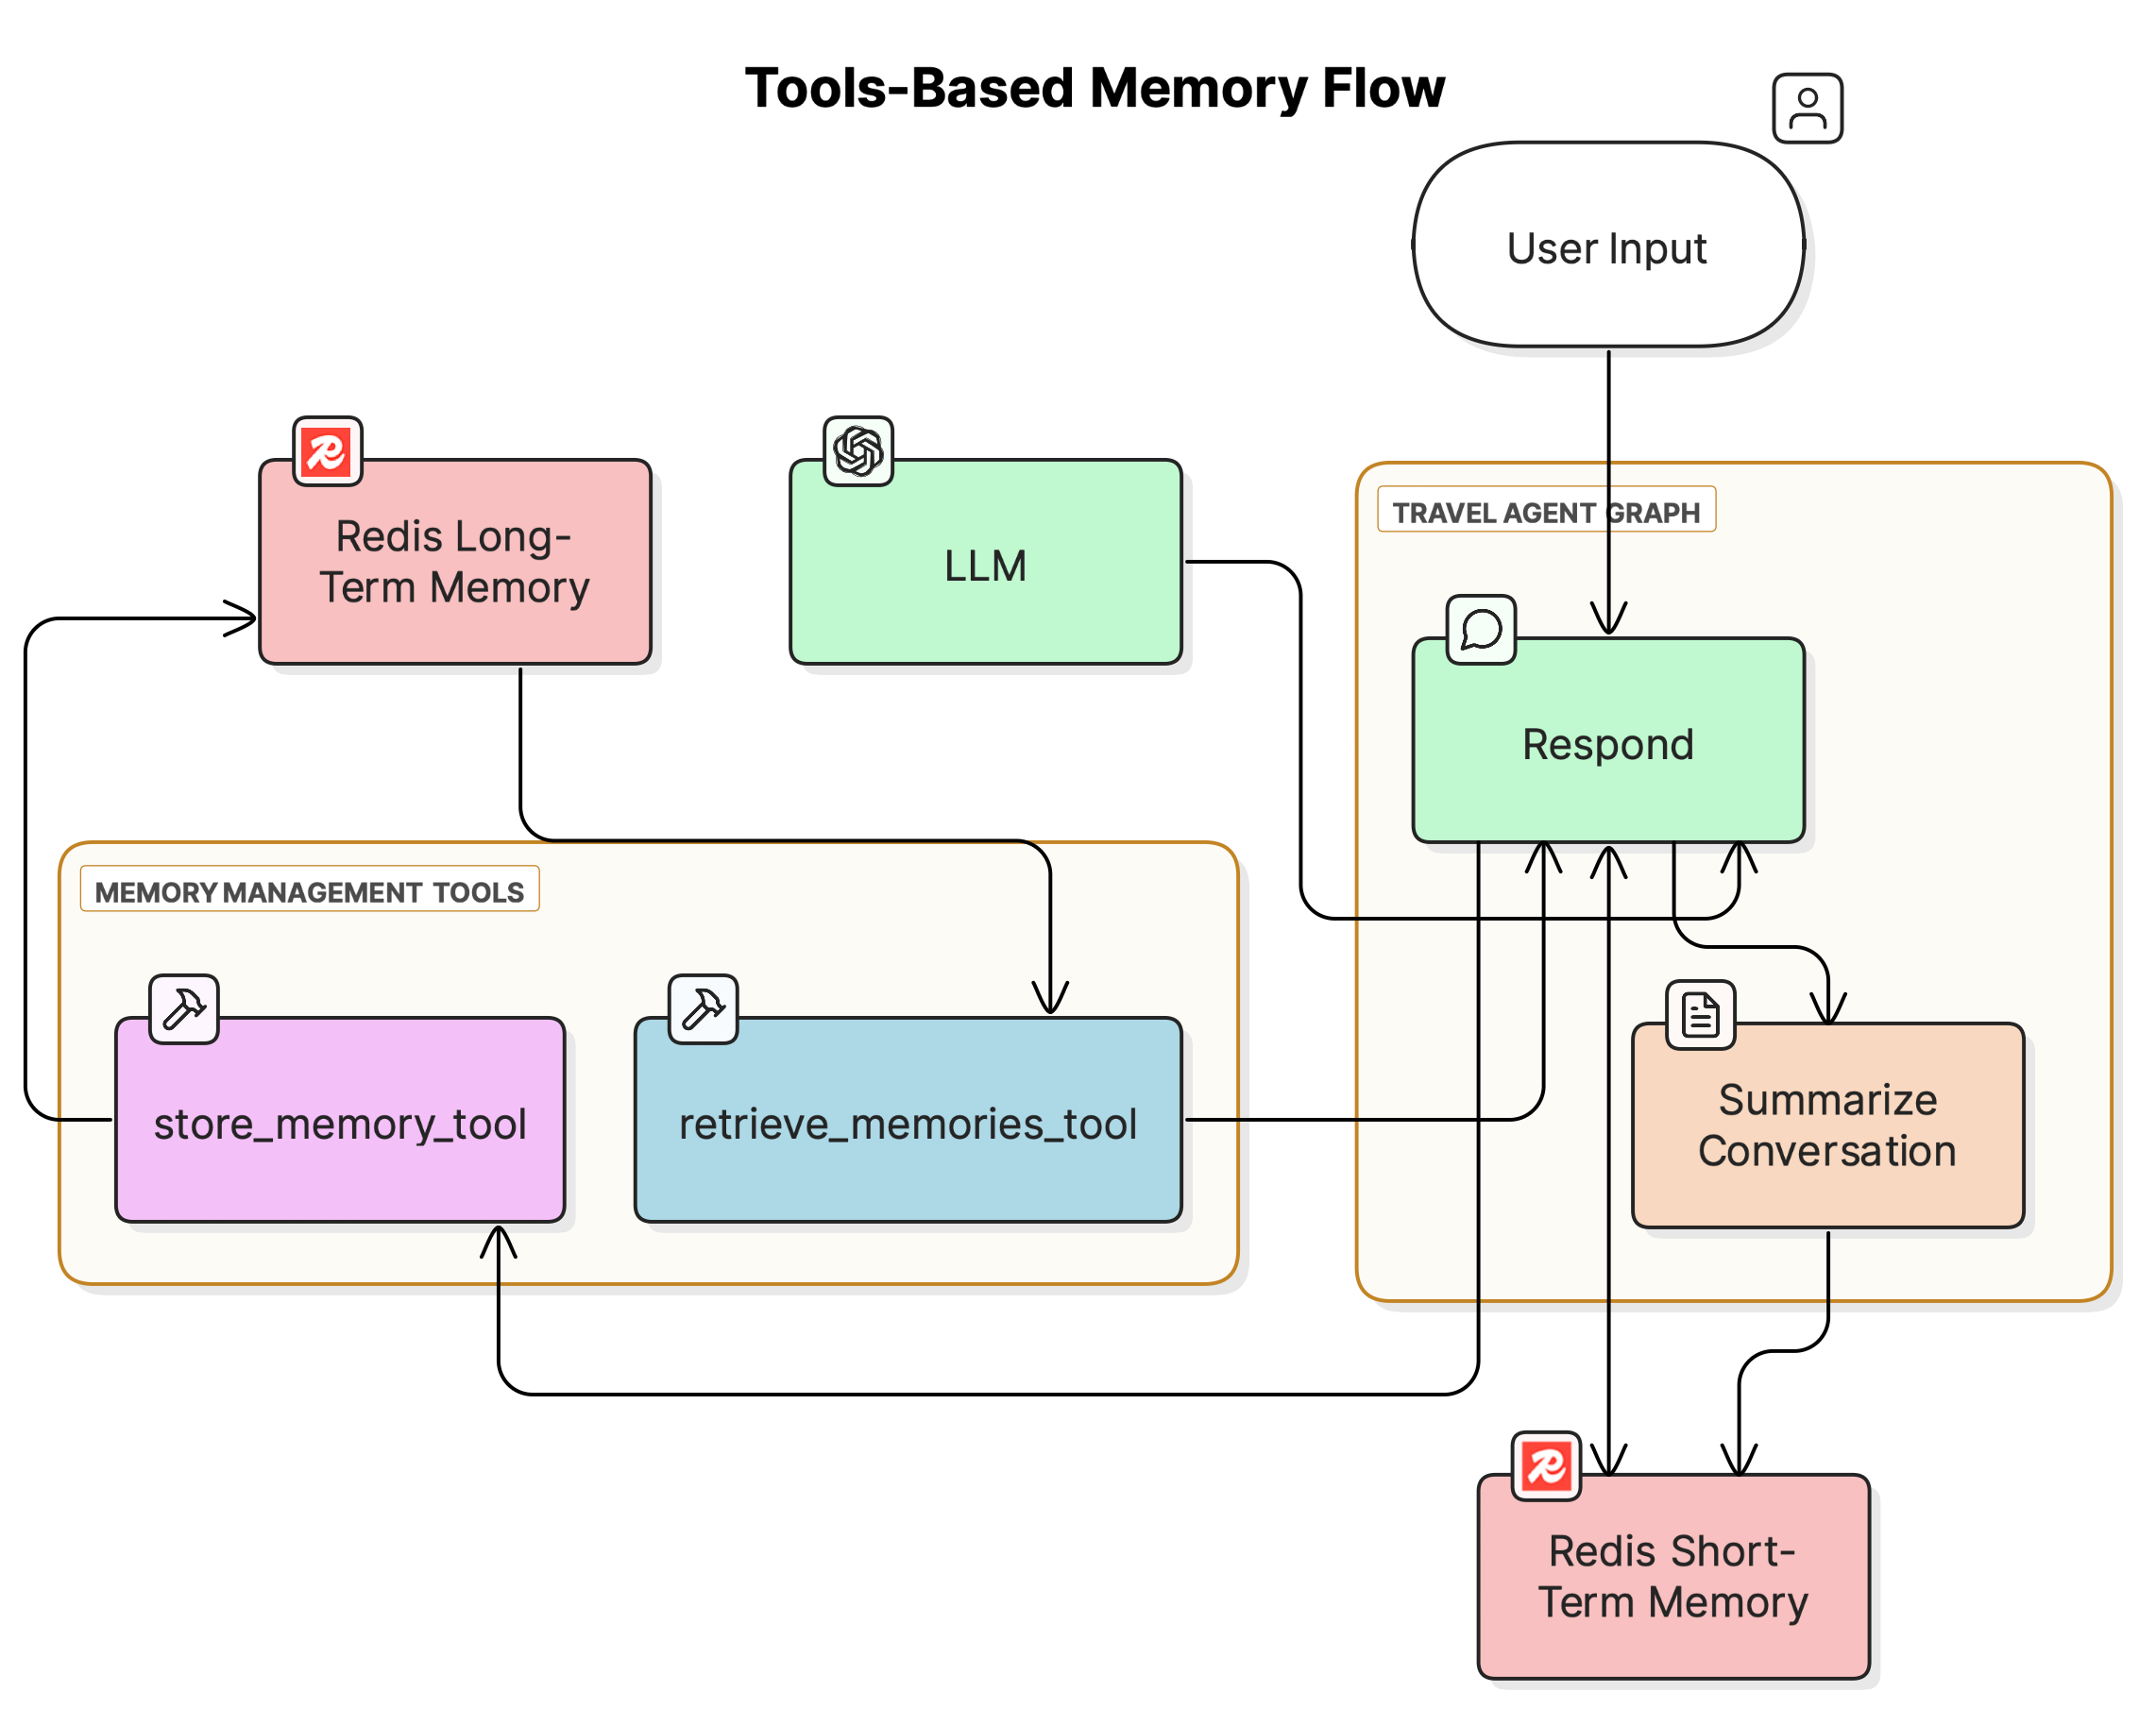

Define Agent Tools
Now that we have our storage functions defined, we can create the tools that will enable our agent to interact with the memory system. These tools will be used by the LLM to manage memories during conversations.

Let's start with the Store Memory Tool:

Store Memory Tool
This tool enables the agent to save important information as long-term memories in Redis. It's particularly useful for capturing:

User preferences and habits
Personal experiences and anecdotes
Important facts and knowledge shared during conversations
The tool accepts the following parameters:

content: The actual memory content to store (e.g., "User prefers window seats on flights")
memory_type: The type of memory (e.g., MemoryType.EPISODIC for personal experiences, MemoryType.SEMANTIC for general knowledge)
metadata: Optional dictionary for additional context (e.g., timestamps, source, confidence)
config: Optional configuration for user/thread context (automatically handled by the agent)
When called, the tool:

Validates the input parameters
Stores the memory in Redis with proper indexing
Returns a success message with the stored content
Handles errors gracefully with informative messages
This tool is designed to be used by the LLM to build a persistent memory of the user's preferences and experiences, enabling more personalized and context-aware interactions over time.

In [22]:
from typing import Dict, Optional

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig


@tool
def store_memory_tool(
    content: str,
    memory_type: MemoryType,
    metadata: Optional[Dict[str, str]] = None,
    config: Optional[RunnableConfig] = None,
) -> str:
    """
    Store a long-term memory in the system.

    Use this tool to save important information about user preferences,
    experiences, or general knowledge that might be useful in future
    interactions.
    """
    config = config or RunnableConfig()
    user_id = config.get("user_id", SYSTEM_USER_ID)
    thread_id = config.get("thread_id")

    try:
        # Store in long-term memory
        store_memory(
            content=content,
            memory_type=memory_type,
            user_id=user_id,
            thread_id=thread_id,
            metadata=str(metadata) if metadata else None,
        )

        return f"Successfully stored {memory_type} memory: {content}"
    except Exception as e:
        return f"Error storing memory: {str(e)}"

In [ ]:
store_memory_tool.invoke({"content": "I like flying on Delta when possible", "memory_type": "episodic"})

**Retrieve Memories Tool**
This tool allows us to search through our stored memories using semantic similarity and filtering.

**This tool is particularly useful when you want to:**

Find relevant past experiences or preferences

Filter memories by type (episodic or semantic)

Get user-specific information

Limit the number of results to keep responses focused

**The tool works by:**

- Taking a query string and searching for semantically similar memories

- Filtering results based on memory type

- Applying a similarity threshold to ensure relevance

- Formatting the results in a clear, readable way

In [23]:
@tool
def retrieve_memories_tool(
    query: str,
    memory_type: List[MemoryType],
    limit: int = 5,
    config: Optional[RunnableConfig] = None,
) -> str:
    """
    Retrieve long-term memories relevant to the query.

    Use this tool to access previously stored information about user
    preferences, experiences, or general knowledge.
    """
    config = config or RunnableConfig()
    user_id = config.get("user_id", SYSTEM_USER_ID)

    try:
        # Get long-term memories
        stored_memories = retrieve_memories(
            query=query,
            memory_type=memory_type,
            user_id=user_id,
            limit=limit,
            distance_threshold=0.3,
        )

        # Format the response
        response = []

        if stored_memories:
            response.append("Long-term memories:")
            for memory in stored_memories:
                response.append(f"- [{memory.memory_type}] {memory.content}")

        return "\n".join(response) if response else "No relevant memories found."

    except Exception as e:
        return f"Error retrieving memories: {str(e)}"

In [ ]:
retrieve_memories_tool.invoke({"query": "Airline preferences", "memory_type": ["episodic"]})

# **Travel Agent**

In [7]:
# !pip install langgraph
# !pip install langgraph-checkpoint-redis
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 9.8 MB/s eta 0:00:00


In [1]:
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.redis import RedisSaver

In [6]:
# Set up the Redis checkpointer for short term memory
redis_saver = RedisSaver(redis_client=redis_client)
redis_saver.setup()

In [28]:
from typing import List, Optional, Dict, Any
from groq import Groq
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.outputs import ChatResult, ChatGeneration
from langchain_core.callbacks import CallbackManagerForLLMRun
from langchain_core.tools import BaseTool

# Initialize Groq client
groq_client = Groq(api_key="")

class GroqChat(BaseChatModel):
    model: str = "llama-3.3-70b-versatile"

    @property
    def _llm_type(self) -> str:
        return "groq-chat"

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        # Convert LangChain messages to Groq format
        groq_messages = []
        for msg in messages:
            if isinstance(msg, SystemMessage):
                role = "system"
            elif isinstance(msg, AIMessage):
                role = "assistant"
            else:
                role = "user"
            groq_messages.append({"role": role, "content": msg.content})

        # Call Groq API
        response = groq_client.chat.completions.create(
            messages=groq_messages,
            model=self.model,
            stop=stop,
            **kwargs
        )

        # Extract the response content
        content = response.choices[0].message.content

        # Create the generation object
        generation = ChatGeneration(message=AIMessage(content=content))

        # Return a ChatResult (not LLMResult)
        return ChatResult(generations=[generation])

    def bind_tools(self, tools: List[BaseTool], **kwargs):
        """Bind tools to the model for tool calling."""
        # For Groq, we'll need to handle tool calling manually
        # since it doesn't natively support function calling
        return self

# Create the model instance
groq_model = GroqChat()

In [9]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         f"""
         You are a travel assistant helping users plan their trips. You remember user preferences
        and provide personalized recommendations based on past interactions.

        You have access to the following types of memory:
        1. Short-term memory: The current conversation thread
        2. Long-term memory:
           - Episodic: User preferences and past trip experiences (e.g., "User prefers window seats")
           - Semantic: General knowledge about travel destinations and requirements

        Your procedural knowledge (how to search, book flights, etc.) is built into your tools and prompts.

        Always be helpful, personal, and context-aware in your responses.
         """),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [24]:
travel_agent = create_react_agent(
            model=groq_model,
            checkpointer=redis_saver,
            tools=[store_memory_tool, retrieve_memories_tool],
            prompt=prompt,

)


In [25]:
from langchain_core.messages import HumanMessage
from langgraph.graph.message import MessagesState


class RuntimeState(MessagesState):
    """Runtime state for the travel agent."""
    pass


def respond_to_user(state: RuntimeState, config: RunnableConfig) -> RuntimeState:
    """Invoke the travel agent to generate a response."""
    human_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]
    if not human_messages:
        logger.warning("No HumanMessage found in state")
        return state

    try:
        # Single agent invocation, not streamed (simplified for reliability)
        result = travel_agent.invoke({"messages": state["messages"]}, config=config)
        agent_message = result["messages"][-1]
        state["messages"].append(agent_message)
    except Exception as e:
        logger.error(f"Error invoking travel agent: {e}")
        agent_message = AIMessage(
            content="I'm sorry, I encountered an error processing your request."
        )
        state["messages"].append(agent_message)

    return state

In [26]:
from langchain_core.messages import ToolMessage


def execute_tools(state: RuntimeState, config: RunnableConfig) -> RuntimeState:
    """Execute tools specified in the latest AIMessage and append ToolMessages.
    This function looks at the latest AI-generated message in the conversation.
    If the AI suggested tool calls, it executes them. Then it appends the results of those tools back into the conversation as ToolMessages.Returns the updated state.
    """
    messages = state["messages"]
    latest_ai_message = next(
        (m for m in reversed(messages) if isinstance(m, AIMessage) and m.tool_calls),
        None
    )

    if not latest_ai_message:
        return state  # No tool calls to process

    tool_messages = []
    for tool_call in latest_ai_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        # Find the corresponding tool
        tool = next((t for t in [store_memory_tool, retrieve_memories_tool] if t.name == tool_name), None)
        if not tool:
            continue  # Skip if tool not found

        try:
            # Execute the tool with the provided arguments
            result = tool.invoke(tool_args, config=config)
            # Create a ToolMessage with the result
            tool_message = ToolMessage(
                content=str(result),
                tool_call_id=tool_id,
                name=tool_name
            )
            tool_messages.append(tool_message)
        except Exception as e:
            # Handle tool execution errors
            error_message = ToolMessage(
                content=f"Error executing tool '{tool_name}': {str(e)}",
                tool_call_id=tool_id,
                name=tool_name
            )
            tool_messages.append(error_message)

    # Append the ToolMessages to the message history
    messages.extend(tool_messages)
    state["messages"] = messages
    return state

In [27]:
from langchain_core.messages import RemoveMessage

# An LLM configured for summarization.

summarizer = groq_model

# The number of messages after which we'll summarize the conversation.
MESSAGE_SUMMARIZATION_THRESHOLD = 6


def summarize_conversation(
    state: RuntimeState, config: RunnableConfig
) -> RuntimeState:
    """
    Summarize a list of messages into a concise summary to reduce context length
    while preserving important information.
    """
    messages = state["messages"]
    current_message_count = len(messages)
    if current_message_count < MESSAGE_SUMMARIZATION_THRESHOLD:
        logger.debug(f"Not summarizing conversation: {current_message_count}")
        return state

    system_prompt = """
    You are a conversation summarizer. Create a concise summary of the previous
    conversation between a user and a travel assistant.

    The summary should:
    1. Highlight key topics, preferences, and decisions
    2. Include any specific trip details (destinations, dates, preferences)
    3. Note any outstanding questions or topics that need follow-up
    4. Be concise but informative

    Format your summary as a brief narrative paragraph.
    """

    message_content = "\n".join(
        [
            f"{'User' if isinstance(msg, HumanMessage) else 'Assistant'}: {msg.content}"
            for msg in messages
        ]
    )

    # Invoke the summarizer
    summary_messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(
            content=f"Please summarize this conversation:\n\n{message_content}"
        ),
    ]

    summary_response = summarizer.invoke(summary_messages)

    logger.info(f"Summarized {len(messages)} messages into a conversation summary")

    summary_message = SystemMessage(
        content=f"""
        Summary of the conversation so far:

        {summary_response.content}

        Please continue the conversation based on this summary and the recent messages.
        """
    )
    remove_messages = [
        RemoveMessage(id=msg.id) for msg in messages if msg.id is not None
    ]

    state["messages"] = [  # type: ignore
        *remove_messages,
        summary_message,
        state["messages"][-1],
    ]

    return state.copy()

In [29]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(RuntimeState)

# Add nodes to the graph
workflow.add_node("agent", respond_to_user)
workflow.add_node("execute_tools", execute_tools)
workflow.add_node("summarize_conversation", summarize_conversation)

def decide_next_step(state):
    latest_ai_message = next((m for m in reversed(state["messages"]) if isinstance(m, AIMessage)), None)
    if latest_ai_message and latest_ai_message.tool_calls:
        return "execute_tools"
    return "summarize_conversation"


workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    decide_next_step,
    {"execute_tools": "execute_tools", "summarize_conversation": "summarize_conversation"},
)
workflow.add_edge("execute_tools", "agent")
workflow.add_edge("summarize_conversation", END)

graph = workflow.compile(checkpointer=redis_saver)

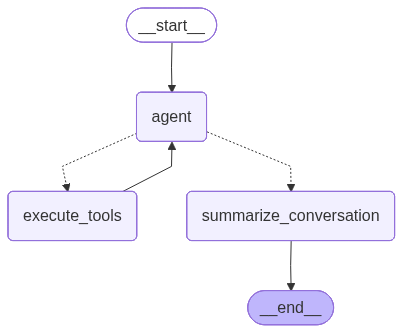

In [30]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
def main(thread_id: str = "book_flight", user_id: str = "demo_user"):
    """Main interaction loop for the travel agent"""

    print("Welcome to the Travel Assistant! (Type 'exit' to quit)")

    config = RunnableConfig(configurable={"thread_id": thread_id, "user_id": user_id})
    state = RuntimeState(messages=[])

    while True:
        user_input = input("\nYou (type 'quit' to quit): ")

        if not user_input:
            continue

        if user_input.lower() in ["exit", "quit"]:
            print("Thank you for using the Travel Assistant. Goodbye!")
            break

        state["messages"].append(HumanMessage(content=user_input))

        try:
            # Process user input through the graph
            for result in graph.stream(state, config=config, stream_mode="values"):
                state = RuntimeState(**result)

            logger.debug(f"# of messages after run: {len(state['messages'])}")

            # Find the most recent AI message, so we can print the response
            ai_messages = [m for m in state["messages"] if isinstance(m, AIMessage)]
            if ai_messages:
                message = ai_messages[-1].content
            else:
                logger.error("No AI messages after run")
                message = "I'm sorry, I couldn't process your request properly."
                # Add the error message to the state
                state["messages"].append(AIMessage(content=message))

            print(f"\nAssistant: {message}")

        except Exception as e:
            logger.exception(f"Error processing request: {e}")
            error_message = "I'm sorry, I encountered an error processing your request."
            print(f"\nAssistant: {error_message}")
            # Add the error message to the state
            state["messages"].append(AIMessage(content=error_message))

In [32]:
try:
    user_id = input("Enter a user ID: ") or "demo_user"
    thread_id = input("Enter a thread ID: ") or "demo_thread"
except Exception:
    # If we're running in CI, we don't have a terminal to input from, so just exit
    exit()
else:
    main(thread_id, user_id)

Enter a user ID: himanshu
Enter a thread ID: 123
Welcome to the Travel Assistant! (Type 'exit' to quit)

You (type 'quit' to quit): hi i plan to go to vietnam with my wife and 1 year kid this summer. any good recommendations? we want less traveling.

Assistant: Vietnam is a wonderful destination. I'd be happy to help you plan a great trip with your family.

Considering you have a 1-year-old kid, I'll suggest places that are kid-friendly and require less traveling. Since you're planning to visit in the summer, I'll also recommend destinations with comfortable weather during that time.

Here are a few options:

1. **Hoi An**: This charming town is perfect for families. The old town is stroller-friendly, and there are many kid-friendly activities, such as visiting the Hoi An Ancient Town, taking a boat ride along the Thu Bon River, or simply enjoying the beautiful beaches like An Bang Beach. The weather in Hoi An is usually warm and sunny during the summer.
2. **Da Nang**: Located near Ho

In [34]:
res = retrieve_memories_tool.invoke({"query": "Travel", "memory_type": ["episodic", "semantic"]})
res.split("\n")

['No relevant memories found.']

In [35]:
from redisvl.query import CountQuery

# count total long-term memories in Redis
long_term_memory_index.query(CountQuery())

0